<a href="https://colab.research.google.com/github/ziatdinovmax/MRS2021/blob/main/08_dkl_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DKL-GPR for active learning
This notebook demonstrates how to use a deep kernel learning (DKL)-based Gaussian process regression (GPR) for data reconstruction and automated experiments. We will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from Kevin Roccapriore.

*Prepared by Maxim Ziatdinov (August 2021)*

Intallations:

In [ ]:
!pip install -q torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1  # the DKL has not been yet thoroughly tested for pytorch>1.8.1
!pip install -q --upgrade git+https://github.com/pycroscopy/atomai.git  # install the latest version from the source

Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import atomai as aoi

Download training data:

In [ ]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [ ]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [ ]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra).

In [ ]:
window_size = 12

coordinates = aoi.utils.get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = aoi.utils.extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

((3264, 12, 12), (3264, 93))

Normalize data:

In [ ]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of largest plasmonic peak but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First do it for a single spectrum:

25 0.7151328805097958


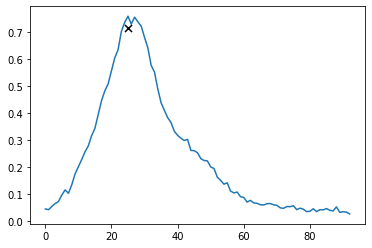

In [ ]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Same but for all the data:

In [ ]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

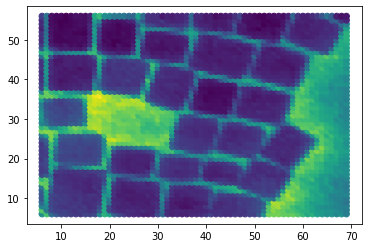

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)

## DKL on full data

Prepare data for training:

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((3264, 144), (3264,))

Train:

In [ ]:
data_dim = X.shape[-1]

dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp.fit(X, y, training_cycles=100)

Epoch 1/100 ... Training loss: 0.7581
Epoch 10/100 ... Training loss: 0.7123
Epoch 20/100 ... Training loss: 0.6735
Epoch 30/100 ... Training loss: 0.6348
Epoch 40/100 ... Training loss: 0.5954
Epoch 50/100 ... Training loss: 0.5549
Epoch 60/100 ... Training loss: 0.5134
Epoch 70/100 ... Training loss: 0.471
Epoch 80/100 ... Training loss: 0.4272
Epoch 90/100 ... Training loss: 0.3844
Epoch 100/100 ... Training loss: 0.3384


Make a "prediction" on the training data (since we used all the data for training, our training and test datasets are the same, that is, we basically look at how well our model was able to "fit" the data):

In [ ]:
mean, var = dklgp.predict(X, batch_size=len(X))

Text(0.5, 1.0, 'DKL uncertainty')

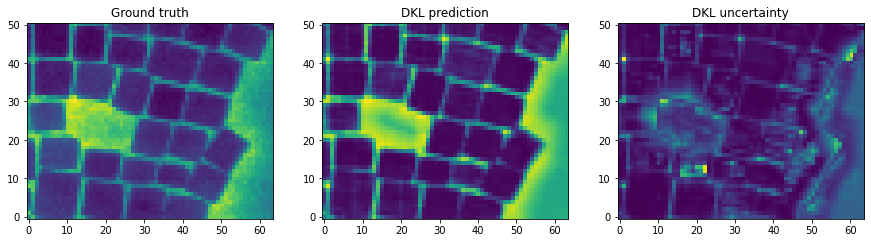

In [ ]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

We can also visualize our latent/embedding space:

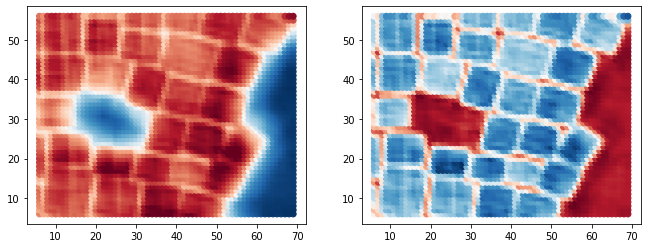

In [ ]:
embeded = dklgp.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## DKL on partial data

Now let's use only a part of the data for training:

In [ ]:
split_ = 30
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

In [ ]:
dklgp1 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp1.fit(X_train, y_train, training_cycles=100)

Epoch 1/100 ... Training loss: 0.768
Epoch 10/100 ... Training loss: 0.7272
Epoch 20/100 ... Training loss: 0.6866
Epoch 30/100 ... Training loss: 0.6481
Epoch 40/100 ... Training loss: 0.6064
Epoch 50/100 ... Training loss: 0.5645
Epoch 60/100 ... Training loss: 0.5183
Epoch 70/100 ... Training loss: 0.4775
Epoch 80/100 ... Training loss: 0.4319
Epoch 90/100 ... Training loss: 0.3884
Epoch 100/100 ... Training loss: 0.3418


Make a prediction on all the data:

In [ ]:
mean, var = dklgp1.predict(X, batch_size=len(X))

Plot the prediction. The dotted vertical line divides the part used for training (left hand side) from the testing (right hand side) part.

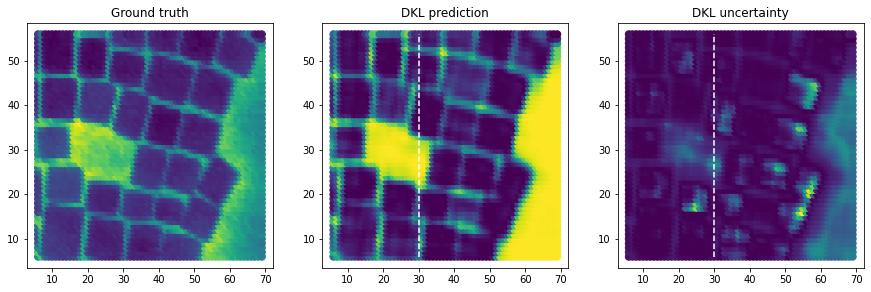

In [ ]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax3.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')

## Active learning

Here we are going to use DKL for active learning aimed at identifying regions of the sample where a particular behavior (plasmon resonance peak) is maximized. We start with just three "measured" points:

In [ ]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unkwown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.999, shuffle=True, random_state=4)

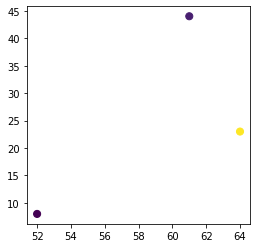

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/40
Epoch 1/200 ... Training loss: 1.023
Epoch 10/200 ... Training loss: 0.9988
Epoch 20/200 ... Training loss: 0.9124
Epoch 30/200 ... Training loss: 0.8479
Epoch 40/200 ... Training loss: 0.7918
Epoch 50/200 ... Training loss: 0.737
Epoch 60/200 ... Training loss: 0.6844
Epoch 70/200 ... Training loss: 0.634
Epoch 80/200 ... Training loss: 0.5851
Epoch 90/200 ... Training loss: 0.5367
Epoch 100/200 ... Training loss: 0.4886
Epoch 110/200 ... Training loss: 0.4408
Epoch 120/200 ... Training loss: 0.3937
Epoch 130/200 ... Training loss: 0.3474
Epoch 140/200 ... Training loss: 0.302
Epoch 150/200 ... Training loss: 0.2577
Epoch 160/200 ... Training loss: 0.2147
Epoch 170/200 ... Training loss: 0.1732
Epoch 180/200 ... Training loss: 0.1333
Epoch 190/200 ... Training loss: 0.0951
Epoch 200/200 ... Training loss: 0.059


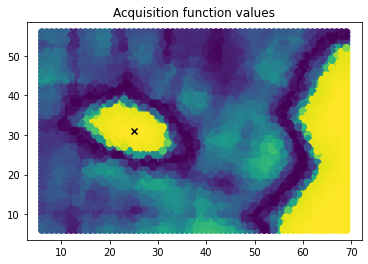

2/40
Epoch 1/200 ... Training loss: 1.0081
Epoch 10/200 ... Training loss: 0.9958
Epoch 20/200 ... Training loss: 0.9294
Epoch 30/200 ... Training loss: 0.8573
Epoch 40/200 ... Training loss: 0.7923
Epoch 50/200 ... Training loss: 0.7302
Epoch 60/200 ... Training loss: 0.6742
Epoch 70/200 ... Training loss: 0.6248
Epoch 80/200 ... Training loss: 0.5768
Epoch 90/200 ... Training loss: 0.5299
Epoch 100/200 ... Training loss: 0.4834
Epoch 110/200 ... Training loss: 0.4373
Epoch 120/200 ... Training loss: 0.3917
Epoch 130/200 ... Training loss: 0.347
Epoch 140/200 ... Training loss: 0.303
Epoch 150/200 ... Training loss: 0.2583
Epoch 160/200 ... Training loss: 0.2053
Epoch 170/200 ... Training loss: 0.1573
Epoch 180/200 ... Training loss: 0.1105
Epoch 190/200 ... Training loss: 0.0684
Epoch 200/200 ... Training loss: 0.0286


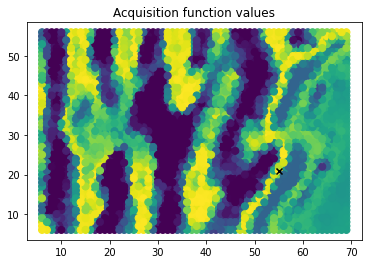

3/40
Epoch 1/200 ... Training loss: 0.978
Epoch 10/200 ... Training loss: 0.9596
Epoch 20/200 ... Training loss: 0.8946
Epoch 30/200 ... Training loss: 0.8402
Epoch 40/200 ... Training loss: 0.7887
Epoch 50/200 ... Training loss: 0.7388
Epoch 60/200 ... Training loss: 0.6903
Epoch 70/200 ... Training loss: 0.6434
Epoch 80/200 ... Training loss: 0.597
Epoch 90/200 ... Training loss: 0.5499
Epoch 100/200 ... Training loss: 0.5046
Epoch 110/200 ... Training loss: 0.4599
Epoch 120/200 ... Training loss: 0.416
Epoch 130/200 ... Training loss: 0.3742
Epoch 140/200 ... Training loss: 0.3301
Epoch 150/200 ... Training loss: 0.2878
Epoch 160/200 ... Training loss: 0.245
Epoch 170/200 ... Training loss: 0.2033
Epoch 180/200 ... Training loss: 0.1645
Epoch 190/200 ... Training loss: 0.1283
Epoch 200/200 ... Training loss: 0.0946


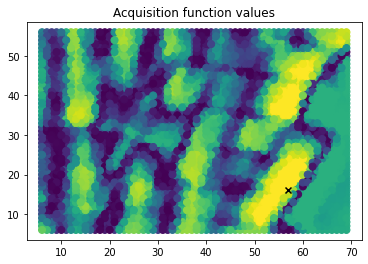

4/40
Epoch 1/200 ... Training loss: 0.9519
Epoch 10/200 ... Training loss: 0.9325
Epoch 20/200 ... Training loss: 0.8746
Epoch 30/200 ... Training loss: 0.8241
Epoch 40/200 ... Training loss: 0.7746
Epoch 50/200 ... Training loss: 0.7261
Epoch 60/200 ... Training loss: 0.6784
Epoch 70/200 ... Training loss: 0.6317
Epoch 80/200 ... Training loss: 0.5871
Epoch 90/200 ... Training loss: 0.5426
Epoch 100/200 ... Training loss: 0.4979
Epoch 110/200 ... Training loss: 0.4531
Epoch 120/200 ... Training loss: 0.4084
Epoch 130/200 ... Training loss: 0.364
Epoch 140/200 ... Training loss: 0.3202
Epoch 150/200 ... Training loss: 0.2778
Epoch 160/200 ... Training loss: 0.2367
Epoch 170/200 ... Training loss: 0.1958
Epoch 180/200 ... Training loss: 0.1567
Epoch 190/200 ... Training loss: 0.1196
Epoch 200/200 ... Training loss: 0.085


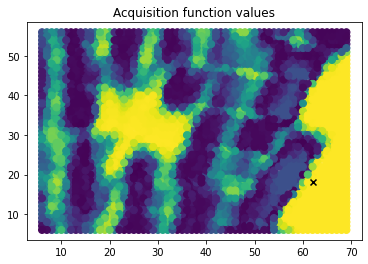

5/40
Epoch 1/200 ... Training loss: 0.9438
Epoch 10/200 ... Training loss: 0.9187
Epoch 20/200 ... Training loss: 0.8654
Epoch 30/200 ... Training loss: 0.8151
Epoch 40/200 ... Training loss: 0.7655
Epoch 50/200 ... Training loss: 0.7185
Epoch 60/200 ... Training loss: 0.6728
Epoch 70/200 ... Training loss: 0.6274
Epoch 80/200 ... Training loss: 0.5818
Epoch 90/200 ... Training loss: 0.5358
Epoch 100/200 ... Training loss: 0.4896
Epoch 110/200 ... Training loss: 0.4446
Epoch 120/200 ... Training loss: 0.3997
Epoch 130/200 ... Training loss: 0.3555
Epoch 140/200 ... Training loss: 0.3121
Epoch 150/200 ... Training loss: 0.2706
Epoch 160/200 ... Training loss: 0.2278
Epoch 170/200 ... Training loss: 0.1858
Epoch 180/200 ... Training loss: 0.1452
Epoch 190/200 ... Training loss: 0.1063
Epoch 200/200 ... Training loss: 0.0692


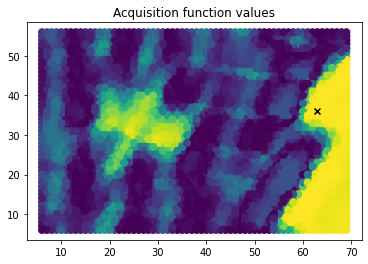

6/40
Epoch 1/200 ... Training loss: 0.9281
Epoch 10/200 ... Training loss: 0.9037
Epoch 20/200 ... Training loss: 0.8504
Epoch 30/200 ... Training loss: 0.8
Epoch 40/200 ... Training loss: 0.7527
Epoch 50/200 ... Training loss: 0.7069
Epoch 60/200 ... Training loss: 0.6617
Epoch 70/200 ... Training loss: 0.6176
Epoch 80/200 ... Training loss: 0.5719
Epoch 90/200 ... Training loss: 0.5253
Epoch 100/200 ... Training loss: 0.4782
Epoch 110/200 ... Training loss: 0.4315
Epoch 120/200 ... Training loss: 0.3855
Epoch 130/200 ... Training loss: 0.3369
Epoch 140/200 ... Training loss: 0.2908
Epoch 150/200 ... Training loss: 0.2462
Epoch 160/200 ... Training loss: 0.2029
Epoch 170/200 ... Training loss: 0.1612
Epoch 180/200 ... Training loss: 0.121
Epoch 190/200 ... Training loss: 0.0824
Epoch 200/200 ... Training loss: 0.0453


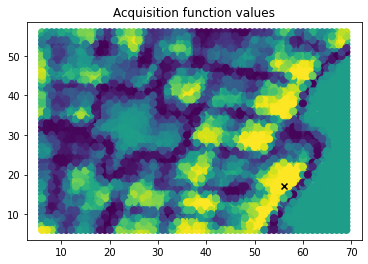

7/40
Epoch 1/200 ... Training loss: 0.9157
Epoch 10/200 ... Training loss: 0.8973
Epoch 20/200 ... Training loss: 0.839
Epoch 30/200 ... Training loss: 0.7918
Epoch 40/200 ... Training loss: 0.7456
Epoch 50/200 ... Training loss: 0.6992
Epoch 60/200 ... Training loss: 0.6524
Epoch 70/200 ... Training loss: 0.6075
Epoch 80/200 ... Training loss: 0.5629
Epoch 90/200 ... Training loss: 0.5184
Epoch 100/200 ... Training loss: 0.4741
Epoch 110/200 ... Training loss: 0.4293
Epoch 120/200 ... Training loss: 0.3841
Epoch 130/200 ... Training loss: 0.3389
Epoch 140/200 ... Training loss: 0.296
Epoch 150/200 ... Training loss: 0.2507
Epoch 160/200 ... Training loss: 0.2069
Epoch 170/200 ... Training loss: 0.1644
Epoch 180/200 ... Training loss: 0.1235
Epoch 190/200 ... Training loss: 0.0842
Epoch 200/200 ... Training loss: 0.0465


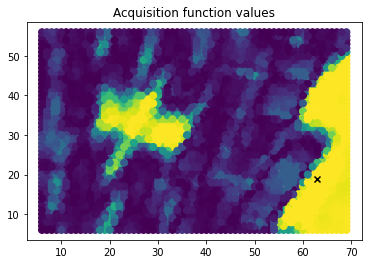

8/40
Epoch 1/200 ... Training loss: 0.9069
Epoch 10/200 ... Training loss: 0.8831
Epoch 20/200 ... Training loss: 0.8319
Epoch 30/200 ... Training loss: 0.7843
Epoch 40/200 ... Training loss: 0.7385
Epoch 50/200 ... Training loss: 0.6937
Epoch 60/200 ... Training loss: 0.6481
Epoch 70/200 ... Training loss: 0.6033
Epoch 80/200 ... Training loss: 0.5587
Epoch 90/200 ... Training loss: 0.514
Epoch 100/200 ... Training loss: 0.469
Epoch 110/200 ... Training loss: 0.4236
Epoch 120/200 ... Training loss: 0.3787
Epoch 130/200 ... Training loss: 0.3339
Epoch 140/200 ... Training loss: 0.2897
Epoch 150/200 ... Training loss: 0.2461
Epoch 160/200 ... Training loss: 0.2022
Epoch 170/200 ... Training loss: 0.1586
Epoch 180/200 ... Training loss: 0.1159
Epoch 190/200 ... Training loss: 0.0748
Epoch 200/200 ... Training loss: 0.035


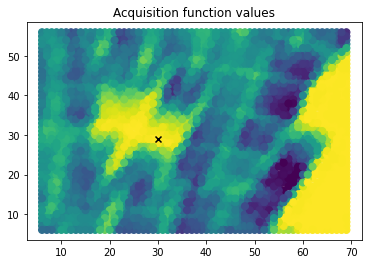

9/40
Epoch 1/200 ... Training loss: 0.9003
Epoch 10/200 ... Training loss: 0.8786
Epoch 20/200 ... Training loss: 0.8284
Epoch 30/200 ... Training loss: 0.7772
Epoch 40/200 ... Training loss: 0.7309
Epoch 50/200 ... Training loss: 0.6858
Epoch 60/200 ... Training loss: 0.6408
Epoch 70/200 ... Training loss: 0.5957
Epoch 80/200 ... Training loss: 0.5502
Epoch 90/200 ... Training loss: 0.5048
Epoch 100/200 ... Training loss: 0.4596
Epoch 110/200 ... Training loss: 0.4143
Epoch 120/200 ... Training loss: 0.3704
Epoch 130/200 ... Training loss: 0.3267
Epoch 140/200 ... Training loss: 0.2795
Epoch 150/200 ... Training loss: 0.2344
Epoch 160/200 ... Training loss: 0.1901
Epoch 170/200 ... Training loss: 0.1463
Epoch 180/200 ... Training loss: 0.1037
Epoch 190/200 ... Training loss: 0.0625
Epoch 200/200 ... Training loss: 0.0225


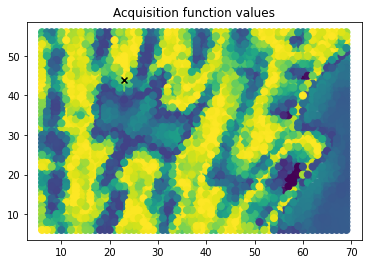

10/40
Epoch 1/200 ... Training loss: 0.893
Epoch 10/200 ... Training loss: 0.8766
Epoch 20/200 ... Training loss: 0.8193
Epoch 30/200 ... Training loss: 0.7711
Epoch 40/200 ... Training loss: 0.7255
Epoch 50/200 ... Training loss: 0.6809
Epoch 60/200 ... Training loss: 0.637
Epoch 70/200 ... Training loss: 0.5932
Epoch 80/200 ... Training loss: 0.549
Epoch 90/200 ... Training loss: 0.5043
Epoch 100/200 ... Training loss: 0.4591
Epoch 110/200 ... Training loss: 0.4137
Epoch 120/200 ... Training loss: 0.3683
Epoch 130/200 ... Training loss: 0.3238
Epoch 140/200 ... Training loss: 0.2807
Epoch 150/200 ... Training loss: 0.2346
Epoch 160/200 ... Training loss: 0.1896
Epoch 170/200 ... Training loss: 0.1452
Epoch 180/200 ... Training loss: 0.1019
Epoch 190/200 ... Training loss: 0.0603
Epoch 200/200 ... Training loss: 0.0195


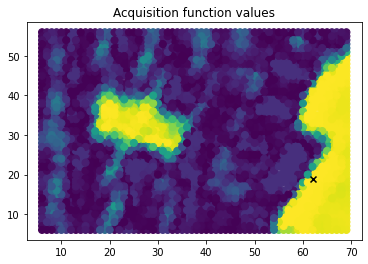

11/40
Epoch 1/200 ... Training loss: 0.8885
Epoch 10/200 ... Training loss: 0.8669
Epoch 20/200 ... Training loss: 0.8162
Epoch 30/200 ... Training loss: 0.7686
Epoch 40/200 ... Training loss: 0.722
Epoch 50/200 ... Training loss: 0.6803
Epoch 60/200 ... Training loss: 0.6533
Epoch 70/200 ... Training loss: 0.589
Epoch 80/200 ... Training loss: 0.5451
Epoch 90/200 ... Training loss: 0.5005
Epoch 100/200 ... Training loss: 0.4554
Epoch 110/200 ... Training loss: 0.4096
Epoch 120/200 ... Training loss: 0.3631
Epoch 130/200 ... Training loss: 0.3164
Epoch 140/200 ... Training loss: 0.2695
Epoch 150/200 ... Training loss: 0.2235
Epoch 160/200 ... Training loss: 0.179
Epoch 170/200 ... Training loss: 0.1355
Epoch 180/200 ... Training loss: 0.0929
Epoch 190/200 ... Training loss: 0.0513
Epoch 200/200 ... Training loss: 0.0103


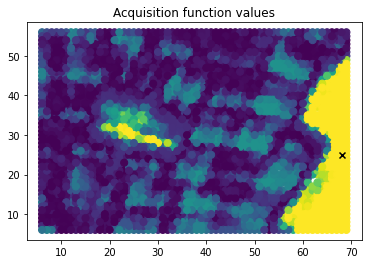

12/40
Epoch 1/200 ... Training loss: 0.882
Epoch 10/200 ... Training loss: 0.8557
Epoch 20/200 ... Training loss: 0.8107
Epoch 30/200 ... Training loss: 0.7637
Epoch 40/200 ... Training loss: 0.7172
Epoch 50/200 ... Training loss: 0.6718
Epoch 60/200 ... Training loss: 0.6275
Epoch 70/200 ... Training loss: 0.5835
Epoch 80/200 ... Training loss: 0.5394
Epoch 90/200 ... Training loss: 0.4951
Epoch 100/200 ... Training loss: 0.4504
Epoch 110/200 ... Training loss: 0.4048
Epoch 120/200 ... Training loss: 0.359
Epoch 130/200 ... Training loss: 0.3134
Epoch 140/200 ... Training loss: 0.2675
Epoch 150/200 ... Training loss: 0.2223
Epoch 160/200 ... Training loss: 0.1787
Epoch 170/200 ... Training loss: 0.1335
Epoch 180/200 ... Training loss: 0.0895
Epoch 190/200 ... Training loss: 0.0465
Epoch 200/200 ... Training loss: 0.0042


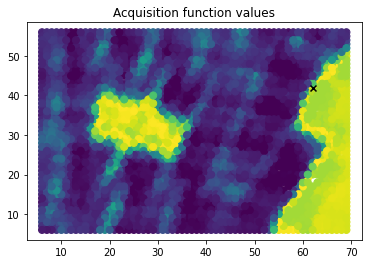

13/40
Epoch 1/200 ... Training loss: 0.8762
Epoch 10/200 ... Training loss: 0.8474
Epoch 20/200 ... Training loss: 0.808
Epoch 30/200 ... Training loss: 0.7575
Epoch 40/200 ... Training loss: 0.7114
Epoch 50/200 ... Training loss: 0.667
Epoch 60/200 ... Training loss: 0.6224
Epoch 70/200 ... Training loss: 0.5786
Epoch 80/200 ... Training loss: 0.5346
Epoch 90/200 ... Training loss: 0.4901
Epoch 100/200 ... Training loss: 0.4451
Epoch 110/200 ... Training loss: 0.3995
Epoch 120/200 ... Training loss: 0.3532
Epoch 130/200 ... Training loss: 0.3069
Epoch 140/200 ... Training loss: 0.2604
Epoch 150/200 ... Training loss: 0.2138
Epoch 160/200 ... Training loss: 0.1681
Epoch 170/200 ... Training loss: 0.1233
Epoch 180/200 ... Training loss: 0.0794
Epoch 190/200 ... Training loss: 0.0363
Epoch 200/200 ... Training loss: -0.0059


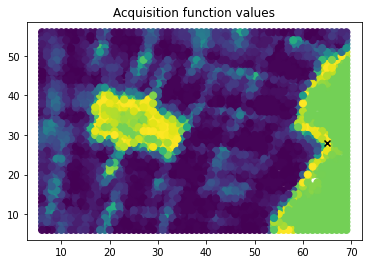

14/40
Epoch 1/200 ... Training loss: 0.8715
Epoch 10/200 ... Training loss: 0.8411
Epoch 20/200 ... Training loss: 0.7954
Epoch 30/200 ... Training loss: 0.7502
Epoch 40/200 ... Training loss: 0.7054
Epoch 50/200 ... Training loss: 0.6612
Epoch 60/200 ... Training loss: 0.6176
Epoch 70/200 ... Training loss: 0.5734
Epoch 80/200 ... Training loss: 0.5292
Epoch 90/200 ... Training loss: 0.4846
Epoch 100/200 ... Training loss: 0.4397
Epoch 110/200 ... Training loss: 0.3942
Epoch 120/200 ... Training loss: 0.3481
Epoch 130/200 ... Training loss: 0.3016
Epoch 140/200 ... Training loss: 0.2546
Epoch 150/200 ... Training loss: 0.2075
Epoch 160/200 ... Training loss: 0.1618
Epoch 170/200 ... Training loss: 0.1168
Epoch 180/200 ... Training loss: 0.0728
Epoch 190/200 ... Training loss: 0.0296
Epoch 200/200 ... Training loss: -0.0128


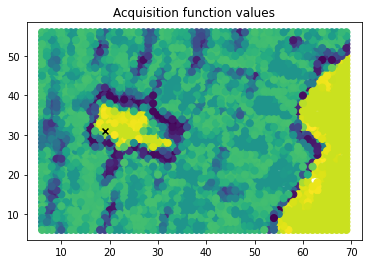

15/40
Epoch 1/200 ... Training loss: 0.8704
Epoch 10/200 ... Training loss: 0.8366
Epoch 20/200 ... Training loss: 0.7919
Epoch 30/200 ... Training loss: 0.7473
Epoch 40/200 ... Training loss: 0.7029
Epoch 50/200 ... Training loss: 0.6594
Epoch 60/200 ... Training loss: 0.6159
Epoch 70/200 ... Training loss: 0.5721
Epoch 80/200 ... Training loss: 0.5279
Epoch 90/200 ... Training loss: 0.4833
Epoch 100/200 ... Training loss: 0.4381
Epoch 110/200 ... Training loss: 0.3922
Epoch 120/200 ... Training loss: 0.3457
Epoch 130/200 ... Training loss: 0.2987
Epoch 140/200 ... Training loss: 0.2522
Epoch 150/200 ... Training loss: 0.2063
Epoch 160/200 ... Training loss: 0.1614
Epoch 170/200 ... Training loss: 0.1173
Epoch 180/200 ... Training loss: 0.0741
Epoch 190/200 ... Training loss: 0.0314
Epoch 200/200 ... Training loss: -0.0107


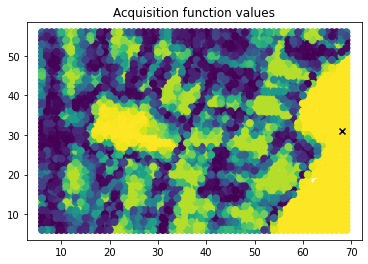

16/40
Epoch 1/200 ... Training loss: 0.8651
Epoch 10/200 ... Training loss: 0.84
Epoch 20/200 ... Training loss: 0.7914
Epoch 30/200 ... Training loss: 0.7466
Epoch 40/200 ... Training loss: 0.701
Epoch 50/200 ... Training loss: 0.6571
Epoch 60/200 ... Training loss: 0.6138
Epoch 70/200 ... Training loss: 0.5701
Epoch 80/200 ... Training loss: 0.5268
Epoch 90/200 ... Training loss: 0.4807
Epoch 100/200 ... Training loss: 0.4372
Epoch 110/200 ... Training loss: 0.3917
Epoch 120/200 ... Training loss: 0.3458
Epoch 130/200 ... Training loss: 0.2993
Epoch 140/200 ... Training loss: 0.2529
Epoch 150/200 ... Training loss: 0.2072
Epoch 160/200 ... Training loss: 0.1621
Epoch 170/200 ... Training loss: 0.1178
Epoch 180/200 ... Training loss: 0.0743
Epoch 190/200 ... Training loss: 0.0317
Epoch 200/200 ... Training loss: -0.0101


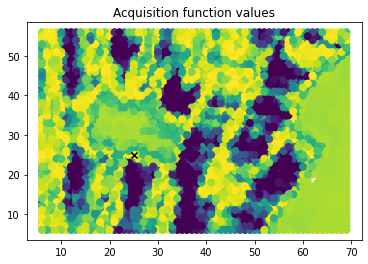

17/40
Epoch 1/200 ... Training loss: 0.8621
Epoch 10/200 ... Training loss: 0.8311
Epoch 20/200 ... Training loss: 0.7864
Epoch 30/200 ... Training loss: 0.7423
Epoch 40/200 ... Training loss: 0.6984
Epoch 50/200 ... Training loss: 0.6543
Epoch 60/200 ... Training loss: 0.6106
Epoch 70/200 ... Training loss: 0.5671
Epoch 80/200 ... Training loss: 0.5232
Epoch 90/200 ... Training loss: 0.4781
Epoch 100/200 ... Training loss: 0.432
Epoch 110/200 ... Training loss: 0.3862
Epoch 120/200 ... Training loss: 0.3407
Epoch 130/200 ... Training loss: 0.2954
Epoch 140/200 ... Training loss: 0.2507
Epoch 150/200 ... Training loss: 0.2068
Epoch 160/200 ... Training loss: 0.163
Epoch 170/200 ... Training loss: 0.1177
Epoch 180/200 ... Training loss: 0.0729
Epoch 190/200 ... Training loss: 0.029
Epoch 200/200 ... Training loss: -0.0146


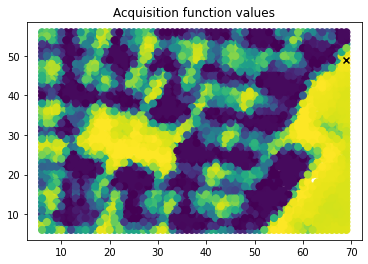

18/40
Epoch 1/200 ... Training loss: 0.8573
Epoch 10/200 ... Training loss: 0.8335
Epoch 20/200 ... Training loss: 0.7836
Epoch 30/200 ... Training loss: 0.738
Epoch 40/200 ... Training loss: 0.6938
Epoch 50/200 ... Training loss: 0.6504
Epoch 60/200 ... Training loss: 0.6084
Epoch 70/200 ... Training loss: 0.5642
Epoch 80/200 ... Training loss: 0.5202
Epoch 90/200 ... Training loss: 0.4756
Epoch 100/200 ... Training loss: 0.4305
Epoch 110/200 ... Training loss: 0.3847
Epoch 120/200 ... Training loss: 0.3388
Epoch 130/200 ... Training loss: 0.2925
Epoch 140/200 ... Training loss: 0.2466
Epoch 150/200 ... Training loss: 0.201
Epoch 160/200 ... Training loss: 0.1558
Epoch 170/200 ... Training loss: 0.1112
Epoch 180/200 ... Training loss: 0.0674
Epoch 190/200 ... Training loss: 0.0245
Epoch 200/200 ... Training loss: -0.0177


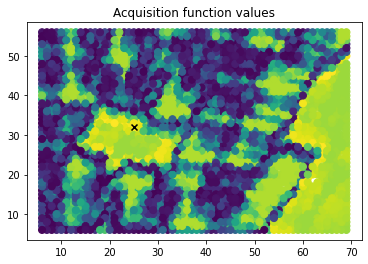

19/40
Epoch 1/200 ... Training loss: 0.8544
Epoch 10/200 ... Training loss: 0.8292
Epoch 20/200 ... Training loss: 0.7811
Epoch 30/200 ... Training loss: 0.7353
Epoch 40/200 ... Training loss: 0.6911
Epoch 50/200 ... Training loss: 0.6479
Epoch 60/200 ... Training loss: 0.6048
Epoch 70/200 ... Training loss: 0.5607
Epoch 80/200 ... Training loss: 0.5177
Epoch 90/200 ... Training loss: 0.4717
Epoch 100/200 ... Training loss: 0.4273
Epoch 110/200 ... Training loss: 0.3815
Epoch 120/200 ... Training loss: 0.3357
Epoch 130/200 ... Training loss: 0.2898
Epoch 140/200 ... Training loss: 0.2444
Epoch 150/200 ... Training loss: 0.1987
Epoch 160/200 ... Training loss: 0.1533
Epoch 170/200 ... Training loss: 0.1081
Epoch 180/200 ... Training loss: 0.0635
Epoch 190/200 ... Training loss: 0.0197
Epoch 200/200 ... Training loss: -0.0236


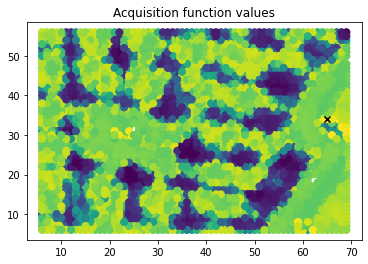

20/40
Epoch 1/200 ... Training loss: 0.8503
Epoch 10/200 ... Training loss: 0.8238
Epoch 20/200 ... Training loss: 0.7751
Epoch 30/200 ... Training loss: 0.7312
Epoch 40/200 ... Training loss: 0.6879
Epoch 50/200 ... Training loss: 0.6448
Epoch 60/200 ... Training loss: 0.6017
Epoch 70/200 ... Training loss: 0.5584
Epoch 80/200 ... Training loss: 0.5143
Epoch 90/200 ... Training loss: 0.4692
Epoch 100/200 ... Training loss: 0.4235
Epoch 110/200 ... Training loss: 0.3777
Epoch 120/200 ... Training loss: 0.3321
Epoch 130/200 ... Training loss: 0.2863
Epoch 140/200 ... Training loss: 0.2405
Epoch 150/200 ... Training loss: 0.1954
Epoch 160/200 ... Training loss: 0.1505
Epoch 170/200 ... Training loss: 0.1059
Epoch 180/200 ... Training loss: 0.0603
Epoch 190/200 ... Training loss: 0.0157
Epoch 200/200 ... Training loss: -0.0283


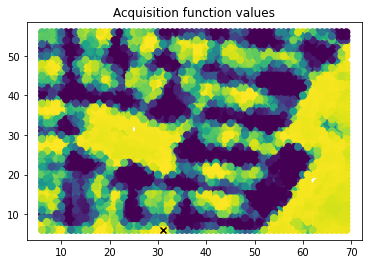

21/40
Epoch 1/200 ... Training loss: 0.8473
Epoch 10/200 ... Training loss: 0.8215
Epoch 20/200 ... Training loss: 0.7756
Epoch 30/200 ... Training loss: 0.7319
Epoch 40/200 ... Training loss: 0.6882
Epoch 50/200 ... Training loss: 0.644
Epoch 60/200 ... Training loss: 0.6001
Epoch 70/200 ... Training loss: 0.5564
Epoch 80/200 ... Training loss: 0.5125
Epoch 90/200 ... Training loss: 0.468
Epoch 100/200 ... Training loss: 0.4226
Epoch 110/200 ... Training loss: 0.3765
Epoch 120/200 ... Training loss: 0.3299
Epoch 130/200 ... Training loss: 0.2837
Epoch 140/200 ... Training loss: 0.2377
Epoch 150/200 ... Training loss: 0.1918
Epoch 160/200 ... Training loss: 0.1464
Epoch 170/200 ... Training loss: 0.1009
Epoch 180/200 ... Training loss: 0.057
Epoch 190/200 ... Training loss: 0.0119
Epoch 200/200 ... Training loss: -0.0331


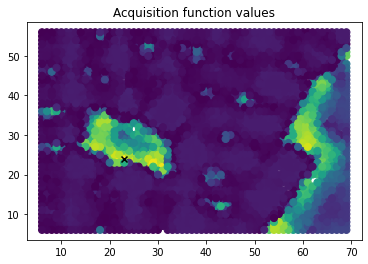

22/40
Epoch 1/200 ... Training loss: 0.8451
Epoch 10/200 ... Training loss: 0.816
Epoch 20/200 ... Training loss: 0.774
Epoch 30/200 ... Training loss: 0.7288
Epoch 40/200 ... Training loss: 0.6843
Epoch 50/200 ... Training loss: 0.6405
Epoch 60/200 ... Training loss: 0.597
Epoch 70/200 ... Training loss: 0.5535
Epoch 80/200 ... Training loss: 0.5097
Epoch 90/200 ... Training loss: 0.4652
Epoch 100/200 ... Training loss: 0.4201
Epoch 110/200 ... Training loss: 0.3746
Epoch 120/200 ... Training loss: 0.3286
Epoch 130/200 ... Training loss: 0.2824
Epoch 140/200 ... Training loss: 0.236
Epoch 150/200 ... Training loss: 0.1899
Epoch 160/200 ... Training loss: 0.1446
Epoch 170/200 ... Training loss: 0.0988
Epoch 180/200 ... Training loss: 0.0534
Epoch 190/200 ... Training loss: 0.0083
Epoch 200/200 ... Training loss: -0.0363


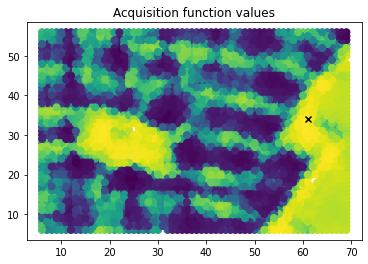

23/40
Epoch 1/200 ... Training loss: 0.8422
Epoch 10/200 ... Training loss: 0.8133
Epoch 20/200 ... Training loss: 0.7699
Epoch 30/200 ... Training loss: 0.7252
Epoch 40/200 ... Training loss: 0.6815
Epoch 50/200 ... Training loss: 0.638
Epoch 60/200 ... Training loss: 0.5946
Epoch 70/200 ... Training loss: 0.5511
Epoch 80/200 ... Training loss: 0.5072
Epoch 90/200 ... Training loss: 0.4628
Epoch 100/200 ... Training loss: 0.4179
Epoch 110/200 ... Training loss: 0.3726
Epoch 120/200 ... Training loss: 0.3269
Epoch 130/200 ... Training loss: 0.2809
Epoch 140/200 ... Training loss: 0.2347
Epoch 150/200 ... Training loss: 0.1884
Epoch 160/200 ... Training loss: 0.1418
Epoch 170/200 ... Training loss: 0.0957
Epoch 180/200 ... Training loss: 0.0501
Epoch 190/200 ... Training loss: 0.005
Epoch 200/200 ... Training loss: -0.0399


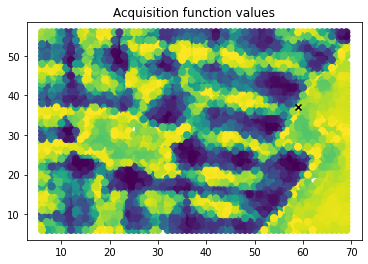

24/40
Epoch 1/200 ... Training loss: 0.8395
Epoch 10/200 ... Training loss: 0.8123
Epoch 20/200 ... Training loss: 0.7658
Epoch 30/200 ... Training loss: 0.7221
Epoch 40/200 ... Training loss: 0.6789
Epoch 50/200 ... Training loss: 0.6359
Epoch 60/200 ... Training loss: 0.5929
Epoch 70/200 ... Training loss: 0.5496
Epoch 80/200 ... Training loss: 0.5056
Epoch 90/200 ... Training loss: 0.4604
Epoch 100/200 ... Training loss: 0.4143
Epoch 110/200 ... Training loss: 0.3682
Epoch 120/200 ... Training loss: 0.322
Epoch 130/200 ... Training loss: 0.2757
Epoch 140/200 ... Training loss: 0.2294
Epoch 150/200 ... Training loss: 0.1836
Epoch 160/200 ... Training loss: 0.139
Epoch 170/200 ... Training loss: 0.0929
Epoch 180/200 ... Training loss: 0.0472
Epoch 190/200 ... Training loss: 0.0011
Epoch 200/200 ... Training loss: -0.0443


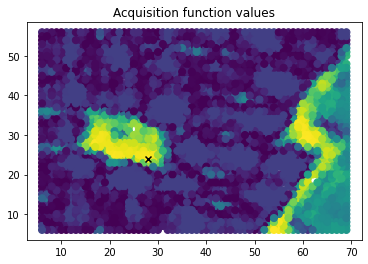

25/40
Epoch 1/200 ... Training loss: 0.8379
Epoch 10/200 ... Training loss: 0.8083
Epoch 20/200 ... Training loss: 0.7669
Epoch 30/200 ... Training loss: 0.7219
Epoch 40/200 ... Training loss: 0.6779
Epoch 50/200 ... Training loss: 0.6346
Epoch 60/200 ... Training loss: 0.591
Epoch 70/200 ... Training loss: 0.5477
Epoch 80/200 ... Training loss: 0.504
Epoch 90/200 ... Training loss: 0.4596
Epoch 100/200 ... Training loss: 0.4143
Epoch 110/200 ... Training loss: 0.3685
Epoch 120/200 ... Training loss: 0.3223
Epoch 130/200 ... Training loss: 0.2762
Epoch 140/200 ... Training loss: 0.2299
Epoch 150/200 ... Training loss: 0.1838
Epoch 160/200 ... Training loss: 0.138
Epoch 170/200 ... Training loss: 0.0919
Epoch 180/200 ... Training loss: 0.0455
Epoch 190/200 ... Training loss: -0.0001
Epoch 200/200 ... Training loss: -0.0455


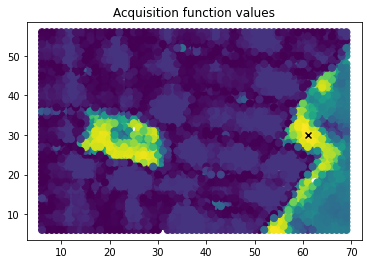

26/40
Epoch 1/200 ... Training loss: 0.8353
Epoch 10/200 ... Training loss: 0.8093
Epoch 20/200 ... Training loss: 0.7639
Epoch 30/200 ... Training loss: 0.7188
Epoch 40/200 ... Training loss: 0.6756
Epoch 50/200 ... Training loss: 0.6329
Epoch 60/200 ... Training loss: 0.5899
Epoch 70/200 ... Training loss: 0.5465
Epoch 80/200 ... Training loss: 0.5024
Epoch 90/200 ... Training loss: 0.4558
Epoch 100/200 ... Training loss: 0.4154
Epoch 110/200 ... Training loss: 0.3706
Epoch 120/200 ... Training loss: 0.325
Epoch 130/200 ... Training loss: 0.2788
Epoch 140/200 ... Training loss: 0.2323
Epoch 150/200 ... Training loss: 0.1858
Epoch 160/200 ... Training loss: 0.1393
Epoch 170/200 ... Training loss: 0.0931
Epoch 180/200 ... Training loss: 0.0469
Epoch 190/200 ... Training loss: 0.0007
Epoch 200/200 ... Training loss: -0.0456


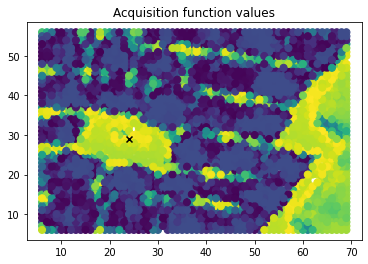

27/40
Epoch 1/200 ... Training loss: 0.8334
Epoch 10/200 ... Training loss: 0.8043
Epoch 20/200 ... Training loss: 0.7613
Epoch 30/200 ... Training loss: 0.7163
Epoch 40/200 ... Training loss: 0.6738
Epoch 50/200 ... Training loss: 0.6305
Epoch 60/200 ... Training loss: 0.5872
Epoch 70/200 ... Training loss: 0.544
Epoch 80/200 ... Training loss: 0.501
Epoch 90/200 ... Training loss: 0.4566
Epoch 100/200 ... Training loss: 0.4117
Epoch 110/200 ... Training loss: 0.3663
Epoch 120/200 ... Training loss: 0.3201
Epoch 130/200 ... Training loss: 0.2736
Epoch 140/200 ... Training loss: 0.2269
Epoch 150/200 ... Training loss: 0.1802
Epoch 160/200 ... Training loss: 0.1335
Epoch 170/200 ... Training loss: 0.0868
Epoch 180/200 ... Training loss: 0.0406
Epoch 190/200 ... Training loss: -0.0053
Epoch 200/200 ... Training loss: -0.0509


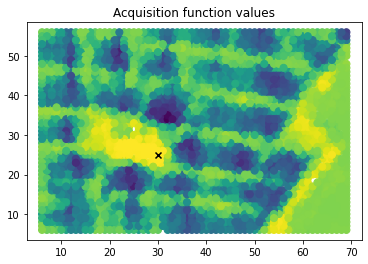

28/40
Epoch 1/200 ... Training loss: 0.8319
Epoch 10/200 ... Training loss: 0.8035
Epoch 20/200 ... Training loss: 0.7588
Epoch 30/200 ... Training loss: 0.715
Epoch 40/200 ... Training loss: 0.6717
Epoch 50/200 ... Training loss: 0.6285
Epoch 60/200 ... Training loss: 0.585
Epoch 70/200 ... Training loss: 0.5409
Epoch 80/200 ... Training loss: 0.4993
Epoch 90/200 ... Training loss: 0.4548
Epoch 100/200 ... Training loss: 0.4099
Epoch 110/200 ... Training loss: 0.3642
Epoch 120/200 ... Training loss: 0.3178
Epoch 130/200 ... Training loss: 0.2712
Epoch 140/200 ... Training loss: 0.2245
Epoch 150/200 ... Training loss: 0.1775
Epoch 160/200 ... Training loss: 0.1307
Epoch 170/200 ... Training loss: 0.0842
Epoch 180/200 ... Training loss: 0.0379
Epoch 190/200 ... Training loss: -0.0082
Epoch 200/200 ... Training loss: -0.0541


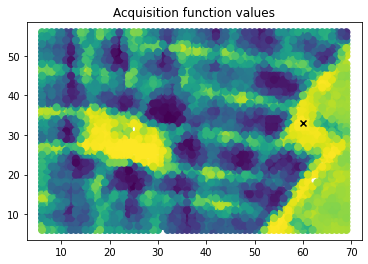

29/40
Epoch 1/200 ... Training loss: 0.8296
Epoch 10/200 ... Training loss: 0.8028
Epoch 20/200 ... Training loss: 0.7567
Epoch 30/200 ... Training loss: 0.7129
Epoch 40/200 ... Training loss: 0.6693
Epoch 50/200 ... Training loss: 0.6264
Epoch 60/200 ... Training loss: 0.5835
Epoch 70/200 ... Training loss: 0.5404
Epoch 80/200 ... Training loss: 0.4967
Epoch 90/200 ... Training loss: 0.4521
Epoch 100/200 ... Training loss: 0.4058
Epoch 110/200 ... Training loss: 0.361
Epoch 120/200 ... Training loss: 0.3145
Epoch 130/200 ... Training loss: 0.2678
Epoch 140/200 ... Training loss: 0.221
Epoch 150/200 ... Training loss: 0.1742
Epoch 160/200 ... Training loss: 0.1275
Epoch 170/200 ... Training loss: 0.0811
Epoch 180/200 ... Training loss: 0.0348
Epoch 190/200 ... Training loss: -0.0114
Epoch 200/200 ... Training loss: -0.0574


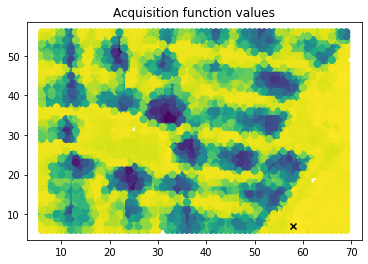

30/40
Epoch 1/200 ... Training loss: 0.8275
Epoch 10/200 ... Training loss: 0.8011
Epoch 20/200 ... Training loss: 0.7553
Epoch 30/200 ... Training loss: 0.7114
Epoch 40/200 ... Training loss: 0.668
Epoch 50/200 ... Training loss: 0.6252
Epoch 60/200 ... Training loss: 0.5824
Epoch 70/200 ... Training loss: 0.5392
Epoch 80/200 ... Training loss: 0.4956
Epoch 90/200 ... Training loss: 0.4514
Epoch 100/200 ... Training loss: 0.4064
Epoch 110/200 ... Training loss: 0.3605
Epoch 120/200 ... Training loss: 0.3138
Epoch 130/200 ... Training loss: 0.2669
Epoch 140/200 ... Training loss: 0.2202
Epoch 150/200 ... Training loss: 0.1756
Epoch 160/200 ... Training loss: 0.1303
Epoch 170/200 ... Training loss: 0.0807
Epoch 180/200 ... Training loss: 0.0337
Epoch 190/200 ... Training loss: -0.0131
Epoch 200/200 ... Training loss: -0.0597


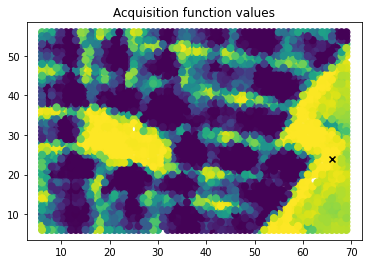

31/40
Epoch 1/200 ... Training loss: 0.8254
Epoch 10/200 ... Training loss: 0.7989
Epoch 20/200 ... Training loss: 0.7519
Epoch 30/200 ... Training loss: 0.7086
Epoch 40/200 ... Training loss: 0.666
Epoch 50/200 ... Training loss: 0.6234
Epoch 60/200 ... Training loss: 0.5806
Epoch 70/200 ... Training loss: 0.5372
Epoch 80/200 ... Training loss: 0.4936
Epoch 90/200 ... Training loss: 0.4497
Epoch 100/200 ... Training loss: 0.4048
Epoch 110/200 ... Training loss: 0.3595
Epoch 120/200 ... Training loss: 0.3134
Epoch 130/200 ... Training loss: 0.2664
Epoch 140/200 ... Training loss: 0.2196
Epoch 150/200 ... Training loss: 0.1728
Epoch 160/200 ... Training loss: 0.1259
Epoch 170/200 ... Training loss: 0.0791
Epoch 180/200 ... Training loss: 0.032
Epoch 190/200 ... Training loss: -0.015
Epoch 200/200 ... Training loss: -0.0617


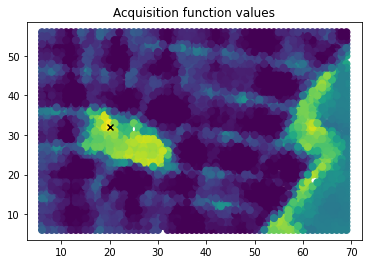

32/40
Epoch 1/200 ... Training loss: 0.8246
Epoch 10/200 ... Training loss: 0.7977
Epoch 20/200 ... Training loss: 0.7508
Epoch 30/200 ... Training loss: 0.7079
Epoch 40/200 ... Training loss: 0.6654
Epoch 50/200 ... Training loss: 0.6229
Epoch 60/200 ... Training loss: 0.5802
Epoch 70/200 ... Training loss: 0.5374
Epoch 80/200 ... Training loss: 0.4936
Epoch 90/200 ... Training loss: 0.4494
Epoch 100/200 ... Training loss: 0.4047
Epoch 110/200 ... Training loss: 0.3595
Epoch 120/200 ... Training loss: 0.3137
Epoch 130/200 ... Training loss: 0.2673
Epoch 140/200 ... Training loss: 0.2202
Epoch 150/200 ... Training loss: 0.1732
Epoch 160/200 ... Training loss: 0.126
Epoch 170/200 ... Training loss: 0.0784
Epoch 180/200 ... Training loss: 0.0314
Epoch 190/200 ... Training loss: -0.0152
Epoch 200/200 ... Training loss: -0.0617


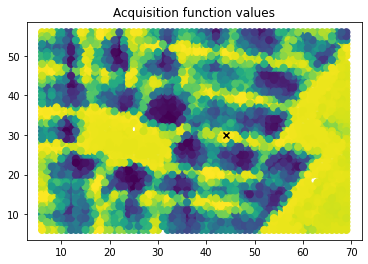

33/40
Epoch 1/200 ... Training loss: 0.8229
Epoch 10/200 ... Training loss: 0.7989
Epoch 20/200 ... Training loss: 0.7546
Epoch 30/200 ... Training loss: 0.7099
Epoch 40/200 ... Training loss: 0.6661
Epoch 50/200 ... Training loss: 0.6227
Epoch 60/200 ... Training loss: 0.5795
Epoch 70/200 ... Training loss: 0.5361
Epoch 80/200 ... Training loss: 0.4936
Epoch 90/200 ... Training loss: 0.4496
Epoch 100/200 ... Training loss: 0.4049
Epoch 110/200 ... Training loss: 0.36
Epoch 120/200 ... Training loss: 0.3146
Epoch 130/200 ... Training loss: 0.2683
Epoch 140/200 ... Training loss: 0.2214
Epoch 150/200 ... Training loss: 0.1743
Epoch 160/200 ... Training loss: 0.1276
Epoch 170/200 ... Training loss: 0.0802
Epoch 180/200 ... Training loss: 0.0318
Epoch 190/200 ... Training loss: -0.0158
Epoch 200/200 ... Training loss: -0.063


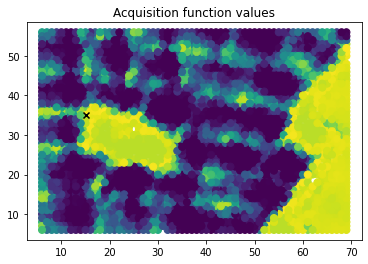

34/40
Epoch 1/200 ... Training loss: 0.8209
Epoch 10/200 ... Training loss: 0.802
Epoch 20/200 ... Training loss: 0.7482
Epoch 30/200 ... Training loss: 0.7058
Epoch 40/200 ... Training loss: 0.6636
Epoch 50/200 ... Training loss: 0.6208
Epoch 60/200 ... Training loss: 0.5777
Epoch 70/200 ... Training loss: 0.5345
Epoch 80/200 ... Training loss: 0.491
Epoch 90/200 ... Training loss: 0.4468
Epoch 100/200 ... Training loss: 0.4018
Epoch 110/200 ... Training loss: 0.3561
Epoch 120/200 ... Training loss: 0.3096
Epoch 130/200 ... Training loss: 0.2627
Epoch 140/200 ... Training loss: 0.2156
Epoch 150/200 ... Training loss: 0.1687
Epoch 160/200 ... Training loss: 0.1218
Epoch 170/200 ... Training loss: 0.0744
Epoch 180/200 ... Training loss: 0.0273
Epoch 190/200 ... Training loss: -0.0197
Epoch 200/200 ... Training loss: -0.0667


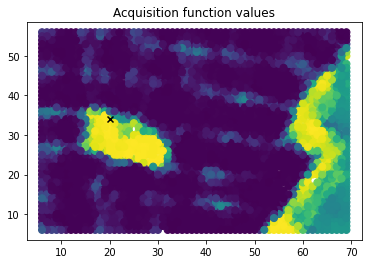

35/40
Epoch 1/200 ... Training loss: 0.8197
Epoch 10/200 ... Training loss: 0.7909
Epoch 20/200 ... Training loss: 0.7477
Epoch 30/200 ... Training loss: 0.7063
Epoch 40/200 ... Training loss: 0.663
Epoch 50/200 ... Training loss: 0.6197
Epoch 60/200 ... Training loss: 0.5764
Epoch 70/200 ... Training loss: 0.5331
Epoch 80/200 ... Training loss: 0.4895
Epoch 90/200 ... Training loss: 0.4451
Epoch 100/200 ... Training loss: 0.3994
Epoch 110/200 ... Training loss: 0.3532
Epoch 120/200 ... Training loss: 0.3072
Epoch 130/200 ... Training loss: 0.2608
Epoch 140/200 ... Training loss: 0.2134
Epoch 150/200 ... Training loss: 0.1665
Epoch 160/200 ... Training loss: 0.1194
Epoch 170/200 ... Training loss: 0.0724
Epoch 180/200 ... Training loss: 0.0253
Epoch 190/200 ... Training loss: -0.0219
Epoch 200/200 ... Training loss: -0.0688


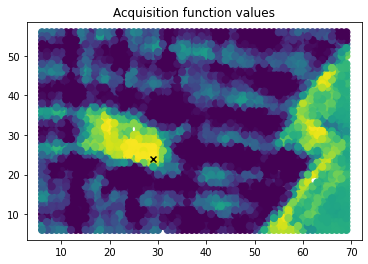

36/40
Epoch 1/200 ... Training loss: 0.8188
Epoch 10/200 ... Training loss: 0.7899
Epoch 20/200 ... Training loss: 0.7483
Epoch 30/200 ... Training loss: 0.7047
Epoch 40/200 ... Training loss: 0.6616
Epoch 50/200 ... Training loss: 0.6184
Epoch 60/200 ... Training loss: 0.5749
Epoch 70/200 ... Training loss: 0.532
Epoch 80/200 ... Training loss: 0.4885
Epoch 90/200 ... Training loss: 0.4442
Epoch 100/200 ... Training loss: 0.3993
Epoch 110/200 ... Training loss: 0.3537
Epoch 120/200 ... Training loss: 0.3076
Epoch 130/200 ... Training loss: 0.261
Epoch 140/200 ... Training loss: 0.2138
Epoch 150/200 ... Training loss: 0.166
Epoch 160/200 ... Training loss: 0.1185
Epoch 170/200 ... Training loss: 0.0713
Epoch 180/200 ... Training loss: 0.0241
Epoch 190/200 ... Training loss: -0.0231
Epoch 200/200 ... Training loss: -0.0702


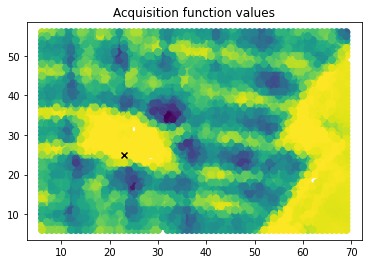

37/40
Epoch 1/200 ... Training loss: 0.8179
Epoch 10/200 ... Training loss: 0.7948
Epoch 20/200 ... Training loss: 0.7476
Epoch 30/200 ... Training loss: 0.704
Epoch 40/200 ... Training loss: 0.6608
Epoch 50/200 ... Training loss: 0.6179
Epoch 60/200 ... Training loss: 0.5749
Epoch 70/200 ... Training loss: 0.5318
Epoch 80/200 ... Training loss: 0.4881
Epoch 90/200 ... Training loss: 0.4432
Epoch 100/200 ... Training loss: 0.3967
Epoch 110/200 ... Training loss: 0.3502
Epoch 120/200 ... Training loss: 0.3037
Epoch 130/200 ... Training loss: 0.2571
Epoch 140/200 ... Training loss: 0.2104
Epoch 150/200 ... Training loss: 0.1635
Epoch 160/200 ... Training loss: 0.1165
Epoch 170/200 ... Training loss: 0.0695
Epoch 180/200 ... Training loss: 0.0223
Epoch 190/200 ... Training loss: -0.0249
Epoch 200/200 ... Training loss: -0.0721


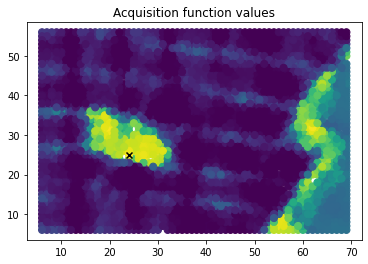

38/40
Epoch 1/200 ... Training loss: 0.8168
Epoch 10/200 ... Training loss: 0.785
Epoch 20/200 ... Training loss: 0.7429
Epoch 30/200 ... Training loss: 0.7103
Epoch 40/200 ... Training loss: 0.6604
Epoch 50/200 ... Training loss: 0.6177
Epoch 60/200 ... Training loss: 0.575
Epoch 70/200 ... Training loss: 0.5316
Epoch 80/200 ... Training loss: 0.4882
Epoch 90/200 ... Training loss: 0.4442
Epoch 100/200 ... Training loss: 0.3995
Epoch 110/200 ... Training loss: 0.3539
Epoch 120/200 ... Training loss: 0.3076
Epoch 130/200 ... Training loss: 0.2607
Epoch 140/200 ... Training loss: 0.2136
Epoch 150/200 ... Training loss: 0.1661
Epoch 160/200 ... Training loss: 0.1186
Epoch 170/200 ... Training loss: 0.0708
Epoch 180/200 ... Training loss: 0.0231
Epoch 190/200 ... Training loss: -0.0243
Epoch 200/200 ... Training loss: -0.0718


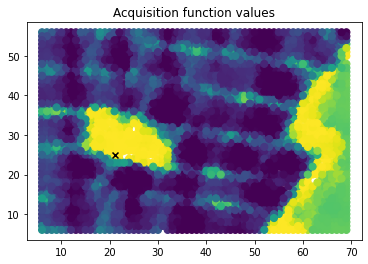

39/40
Epoch 1/200 ... Training loss: 0.8163
Epoch 10/200 ... Training loss: 0.789
Epoch 20/200 ... Training loss: 0.7421
Epoch 30/200 ... Training loss: 0.7004
Epoch 40/200 ... Training loss: 0.6586
Epoch 50/200 ... Training loss: 0.6164
Epoch 60/200 ... Training loss: 0.5737
Epoch 70/200 ... Training loss: 0.5304
Epoch 80/200 ... Training loss: 0.4865
Epoch 90/200 ... Training loss: 0.456
Epoch 100/200 ... Training loss: 0.4001
Epoch 110/200 ... Training loss: 0.3555
Epoch 120/200 ... Training loss: 0.3103
Epoch 130/200 ... Training loss: 0.2644
Epoch 140/200 ... Training loss: 0.2178
Epoch 150/200 ... Training loss: 0.1707
Epoch 160/200 ... Training loss: 0.1231
Epoch 170/200 ... Training loss: 0.0742
Epoch 180/200 ... Training loss: 0.0254
Epoch 190/200 ... Training loss: -0.0226
Epoch 200/200 ... Training loss: -0.0704


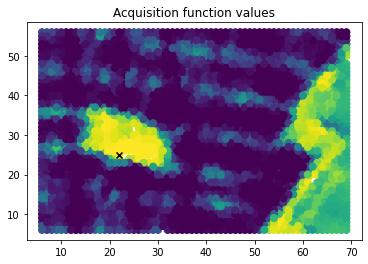

40/40
Epoch 1/200 ... Training loss: 0.8154
Epoch 10/200 ... Training loss: 0.7837
Epoch 20/200 ... Training loss: 0.741
Epoch 30/200 ... Training loss: 0.6996
Epoch 40/200 ... Training loss: 0.6578
Epoch 50/200 ... Training loss: 0.6157
Epoch 60/200 ... Training loss: 0.5728
Epoch 70/200 ... Training loss: 0.5298
Epoch 80/200 ... Training loss: 0.4864
Epoch 90/200 ... Training loss: 0.4424
Epoch 100/200 ... Training loss: 0.3976
Epoch 110/200 ... Training loss: 0.352
Epoch 120/200 ... Training loss: 0.3059
Epoch 130/200 ... Training loss: 0.2594
Epoch 140/200 ... Training loss: 0.2123
Epoch 150/200 ... Training loss: 0.1654
Epoch 160/200 ... Training loss: 0.1183
Epoch 170/200 ... Training loss: 0.07
Epoch 180/200 ... Training loss: 0.0223
Epoch 190/200 ... Training loss: -0.0252
Epoch 200/200 ... Training loss: -0.0729


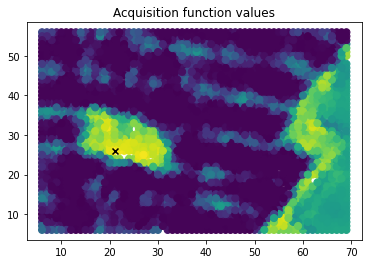

In [ ]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=50, c=obj)
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 40

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dklgp2 = aoi.models.dklGPR(data_dim, embedim=2, precision="double")
    dklgp2.fit(X_train, y_train, training_cycles=200)
    # Thompson sampling
    obj, next_point_idx = dklgp2.thompson(X_test)
    # Select next point to "measure"
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point, 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

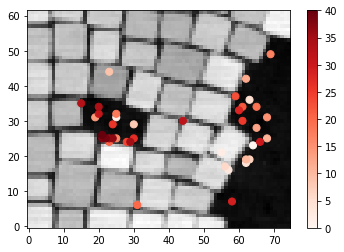

In [ ]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

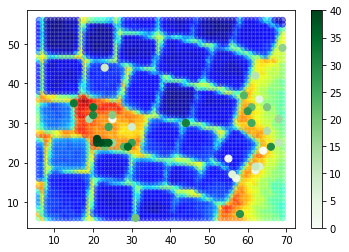

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of intetest is maximized. We note that in addition to the built-in Thompson sampler used here, one can utilize different types of [acquisition functions](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf) for selecting the next measurement points.